# 1. 实验说明
本实验基于[本人博客](https://blog.csdn.net/ygf666/article/details/127182480?spm=1001.2014.3001.5502)
在该博客中，使用了MH采样，对最简单的贝叶斯网络：

$$ y_n = \beta_0 + \beta x_n + N(0,\sigma) $$

进行训练。

# 2. 源文件的实验内容

1. 导入所需要的库
```bash
pip install altair scipy matplotlib
pip install certifi
pip install pytorch-lightning-bolts==0.2.5
pip install pytorch-lightning==0.10.0
```

In [5]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.optim.optimizer import Optimizer
import copy
import random

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats


3. 创建数据

In [6]:
N = 50
beta0 = torch.tensor([-1.0])
beta_true = torch.tensor([2.0])
sigma_true = torch.tensor([0.5])

X = dist.Uniform(-1,1).sample((N,))
Y = beta0 + X *beta_true + sigma_true*torch.normal(0,1, (N,))
data = {'x' : X,'y' : Y}


4. 模型构建

In [7]:
class BayesNet_o(nn.Module):
    def __init__(self, seed = 42):
        super().__init__()
        torch.random.manual_seed(seed)
        # Initialize the parameters with some random values
        self.beta0 = nn.Parameter(torch.tensor([0.0]))
        self.beta = nn.Parameter(torch.tensor([0.0]))
        self.sigma = nn.Parameter(torch.tensor([1.0]) ) # this has to be positive
    def forward(self, data: dict):
        return self.beta0 + self.beta*data['x']

    def loglik(self, data):
        # Evaluates the log of the likelihood given a set of X and Y
        yhat = self.forward(data)
        logprob = dist.Normal(yhat, self.sigma.abs()).log_prob(data['y'])
        return logprob.sum() / data["y"].shape[0] * 50

    def logprior(self):
        # Return a scalar of 0 since we have uniform prior
        return torch.tensor(0.0)

    def logpost(self, data):
        return self.loglik(data) + self.logprior()


In [4]:
# 模型实例化
model = BayesNet_o(seed =42)
model.loglik(data)
# 模型验证
beta, beta0, r_value, p_value, std_err = scipy.stats.linregress(data['x'], data['y'])
print(f"MLE estimates: beta_0 = {beta0:.2f}, beta = {beta:.2f}")

MLE estimates: beta_0 = -0.95, beta = 2.06


5. 优化器构建

In [8]:
from tqdm import tqdm
class MetropolisOptimizer():
    def __init__(self, net, alpha):
        super().__init__()
        self.net = net
        self.alpha = alpha
        self.d = sum(p.numel() for p in self.net.parameters())

    @torch.no_grad()
    def step(self, data=None):
        # Step 1:
        proposal_net = copy.deepcopy(self.net) # we copy the whole network instead of just the parameters for simplicity
        for name, par in proposal_net.named_parameters():
            newpar = par + torch.normal(torch.zeros_like(par), self.alpha)
            par.copy_(newpar)

        # Step 2: calculate ratio
        
        ratio = torch.exp(proposal_net.logpost(data) - self.net.logpost(data))
        
        #print(proposal_net.logpost(data) - self.net.logpost(data),ratio)
        # Step 3: update with some probability:
        if (random.random()<ratio).bool():
            self.net = proposal_net
        else:
            pass
        return self.net

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
        parameter_trace = np.empty([num_steps, self.d])

        for s in tqdm(range(num_steps)):
            current_net = self.step(data)
            j = 0
            for key, val in current_net.named_parameters():
                parameter_trace[s:(s + 1),j] = val.data
                j = j + 1
        return parameter_trace

6. MH训练

-------使用MH优化器优化---------


100%|██████████| 1500/1500 [00:00<00:00, 1766.78it/s]


Wall time: 853 ms


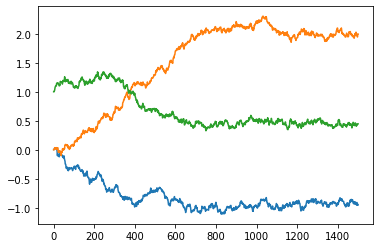

In [6]:

print("-------使用MH优化器优化---------")
# 实例化模型
import numpy as np
model = BayesNet_o()
# 实例化优化器，优化的对象就是上述模型
trainer = MetropolisOptimizer(model, alpha=0.02)
%time parameter_trace = trainer.fit(data, num_steps=1500)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i in range(trainer.d):
    plt.plot(line,parameter_trace[:,i],label="par"+str(i))
plt.show()

# 改进部分一：并行多建议（[并行MCMC的一般结构](https://www.pnas.org/doi/pdf/10.1073/pnas.1408184111)）

## 1.模型修改
在 A general construction for parallelizing Metropolis−Hastings algorithms 论文中提到的，需要对先验，也就是对转移的概率进行计算，当转移并非对称时，需要计算转移概率。因此需要修改logprior（）函数。

In [9]:
from scipy import stats
class BayesNet(nn.Module):
    def __init__(self, seed = 42):
        super().__init__()
        torch.random.manual_seed(seed)
        # Initialize the parameters with some random values
        self.beta0 = nn.Parameter(torch.tensor([0.0]))
        self.beta = nn.Parameter(torch.tensor([0.0]))
        self.sigma = nn.Parameter(torch.tensor([1.0]) ) # this has to be positive

    def forward(self, data: dict):
        return self.beta0 + self.beta*data['x']
        
    def loglik(self, data):
        # Evaluates the log of the likelihood given a set of X and Y
        yhat = self.forward(data)
        logprob = dist.Normal(yhat, self.sigma.abs()).log_prob(data['y'])
        
        return logprob.sum() / data["y"].shape[0] * 50
        

def log_trans_prob(net,net_star):
    log_trans_prob = torch.tensor([0],dtype=torch.float64)
    for p,p_star in zip(net.parameters(),net_star.parameters()): 
        log_trans_prob = log_trans_prob + torch.log(torch.tensor([stats.norm.pdf(p.detach().numpy()[0],p_star.detach().numpy()[0])]))  
    return log_trans_prob

        
## test
mo = BayesNet()
me = BayesNet()
log_trans_prob(mo,me).item()


-2.756815599614018

In [84]:
from tqdm import tqdm 
import numpy as np
import math
class GMOptimizer():
    def __init__(self, net, alpha ,N):
        super().__init__()
        self.net = net #model
        self.alpha = alpha #learning radio
        self.N = N # parallel number
        self.d = sum(p.numel() for p in self.net.parameters()) #参数维度为d
    @torch.no_grad()
    def update(self,net):
        my_net = copy.deepcopy(net)
        for name, par in my_net.named_parameters():
            newpar = par + torch.normal(torch.zeros_like(par), self.alpha)
            par.copy_(newpar)
        return my_net

    @torch.no_grad()
    def step(self, data=None,proposal_nets=None):
        # Step 1:
        # 计算接受率（可并行）
        K = np.empty([self.N+1 , 1])
        A = np.empty([self.N+1 , 1])
        for j in range(self.N+1):
            temp = 0
            for k in range( self.N+1):
                K[k] = log_trans_prob(proposal_nets[j],proposal_nets[k]).item()
                if j!=k :
                    temp += K[k]
            A[j, 0] = temp + proposal_nets[j].loglik(data).item()
            #print("proposal_nets[j].loglik(data).item()",proposal_nets[j].loglik(data).item())
        # 根据接受率采样
        
        B = pd.DataFrame(np.exp(A).reshape(-1))
        index = pd.DataFrame(np.linspace(0, self.N, self.N + 1).astype(np.int32))
       
        index_weight = index.sample(self.N+1,replace=True, weights=B[0]).values.reshape(-1)
     
        new_proposal_nets = copy.deepcopy(proposal_nets)
        for i,j in zip(index_weight,index.values.reshape(-1)):
            new_proposal_nets[j] = proposal_nets[i]
        
        I = np.random.choice(np.linspace(0, self.N, self.N + 1).astype(np.int32), 1)
        self.net = new_proposal_nets[I[0]]
        return new_proposal_nets

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
      
        parameter_trace = np.empty([num_steps, self.d])
        proposal_nets = {}
        for s in tqdm(range(num_steps)):
            # 1.建议参数
            proposal_nets[0] = copy.deepcopy(self.net)
            # generate N new points from the proposal 初始化产生N个建议网络（可并行）
    
            for i in range(1,self.N+1):
                
                proposal_nets[i] = copy.deepcopy(self.update(proposal_nets[0]))
               
            
            # 2.优化采样
            current_nets = self.step(data,proposal_nets)
            # 3.记录样本
            j = 0
            for key, val in current_nets[0].named_parameters():
                parameter_trace[s:(s + 1),j] = val.data
                j = j + 1
        return parameter_trace

100%|██████████| 2000/2000 [00:09<00:00, 219.17it/s]


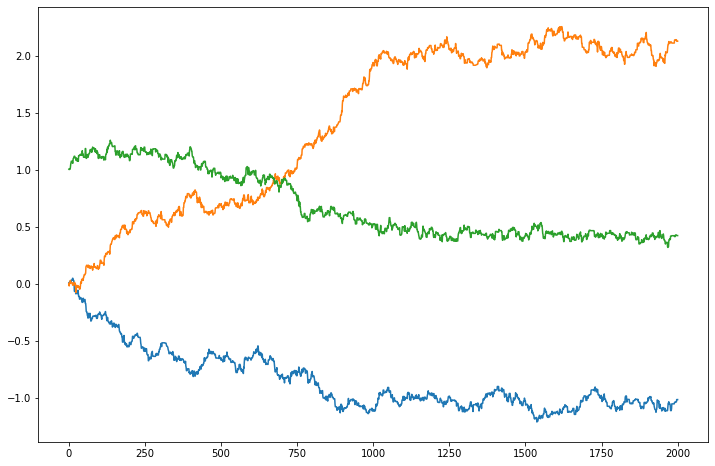

In [86]:


model = BayesNet()
# 实例化优化器，优化的对象就是上述模型
trainer = GMOptimizer(model, alpha=0.02,N = 1)

parameter_trace = trainer.fit(data, num_steps=2000)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i in range(trainer.d):
    plt.plot(line,parameter_trace[:,i],label="par"+str(i))
plt.show()

In [11]:
class preMOptimizer():
    def __init__(self, net, alpha, N):
        super().__init__()
        self.net = net #model
        self.alpha = alpha #learning radio
        self.N = N # parallel number log2(N+1)
        self.d = sum(p.numel() for p in self.net.parameters()) #参数维度为d

    @torch.no_grad()
    def update(self,net):
        my_net = copy.deepcopy(net)
        for name, par in my_net.named_parameters():
            newpar = par + torch.normal(torch.zeros_like(par), self.alpha)
            par.copy_(newpar)
        return my_net

    @torch.no_grad()
    def step(self, data=None,proposal_nets=None):
        # Step 1:
        # 计算接受率（可并行）
        tree_deep = math.log2(self.N+1)
        K = np.empty([self.N+1 , 1])
        A = np.zeros([self.N+1 , 1])
        weights = np.empty([self.N + 1, 1])
        for all in range(self.N + 1):
            weights[all, 0] = np.exp(proposal_nets[all].loglik(data).item())
        # 计算接受率（可并行）
        for all in range(self.N+1):
            for c in range(int(tree_deep)):
                judg = all
                j = int(math.pow(2,c+1))
                half_j = int(j/2)
                if judg>0:
                    deep = int(math.log2(judg))
                while(judg > j -1 ):
                    if judg >= int(math.pow(2, deep)):
                        judg = judg - int(math.pow(2, deep))

                    deep = deep - 1
                if(judg < half_j):
                    w_new = weights[judg, 0] * np.exp(log_trans_prob(proposal_nets[judg], proposal_nets[judg+half_j]).item())
                    w_old = weights[judg + half_j, 0] * np.exp(log_trans_prob(proposal_nets[judg+half_j], proposal_nets[judg]).item())
                   
                else:
                    w_new = weights[judg, 0] * np.exp(log_trans_prob(proposal_nets[judg], proposal_nets[judg-half_j]).item())
                    w_old = weights[judg - half_j, 0] * np.exp(log_trans_prob(proposal_nets[judg-half_j], proposal_nets[judg]).item())
                
                A[all, 0] = A[all, 0] + np.log(w_new / (w_new + w_old))
           
        #A = (A - np.mean(A)) / np.std(A)
        # 根据接受率采样    
        B = pd.DataFrame(np.exp(A).reshape(-1))

        index = pd.DataFrame(np.linspace(0, self.N, self.N + 1).astype(np.int32))

        index_weight = index.sample(self.N+1,replace=True, weights=B[0]).values.reshape(-1)
     
        new_proposal_nets = copy.deepcopy(proposal_nets)
        for i,j in zip(index_weight,index.values.reshape(-1)):
            new_proposal_nets[j] = proposal_nets[i]
        
        I = np.random.choice(np.linspace(0, self.N, self.N + 1).astype(np.int32), 1)
        
        self.net = new_proposal_nets[I[0]]

        return new_proposal_nets
    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
      
        parameter_trace = np.empty([num_steps, self.d])
        proposal_nets = {}
        tree_deep = math.log2(self.N+1)
        
        for s in tqdm(range(num_steps)):
            proposal_nets[0] = copy.deepcopy(self.net)
            for i in range(int(tree_deep)):
                j = int(math.pow(2,i))
                for k in range(int(j)):
                    proposal_nets[k+j] = copy.deepcopy(self.update(proposal_nets[k]))
                
            current_nets = self.step(data,proposal_nets)
            j = 0
            for key, val in self.net.named_parameters():
                parameter_trace[s:(s + 1),j] = val.data
                j = j + 1
        return parameter_trace

# 改进部分3：预取并行多建议优化

-------使用pre_M优化器优化---------


100%|██████████| 500/500 [00:12<00:00, 39.33it/s]

Wall time: 12.7 s


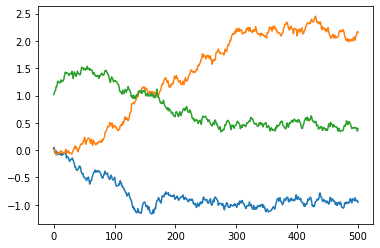

In [9]:



print("-------使用pre_M优化器优化---------")
# 实例化模型
model = BayesNet()
# 实例化优化器，优化的对象就是上述模型
trainer = preMOptimizer(model, alpha=0.02,N=7)
%time parameter_trace = trainer.fit(data, num_steps=500)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i in range(trainer.d):
    plt.plot(line,parameter_trace[:,i],label="par"+str(i))
plt.show()


# 改进部分4：基于GMP的预取并行多建议优化

In [12]:
from tqdm import tqdm 
import numpy as np
import math
class GMpreOptimizerV2():
    def __init__(self, net, alpha, N, deep):
        super().__init__()
        self.net = net # model
        self.alpha = alpha # learning radio
        self.N = N # parallel number
        self.deep = deep
        self.d = sum(p.numel() for p in self.net.parameters()) #参数维度为d
    @torch.no_grad()
    def update(self,net):
        my_net = copy.deepcopy(net)
        for name, par in my_net.named_parameters():
            newpar = par + torch.normal(torch.zeros_like(par), self.alpha)
            par.copy_(newpar)
        return my_net

    @torch.no_grad()
    def step(self, data=None,proposal_nets=None):
        # Step 1:
        # 计算接受率（可并行）
        
        A = np.ones([(self.N+1) ** self.deep , 1])
        weights = np.empty([(self.N + 1) ** self.deep , 1])
        w_t = np.ones([self.N + 1, 1])
        for all in range((self.N + 1) ** self.deep):
            weights[all, 0] = np.exp(proposal_nets[all].loglik(data).item())
            
        # 计算接受率
        for i in range(self.deep):
            temp = (self.N+1)**i
            for h in range((self.N+1)**i):
                
                for j in range(self.N+1):
                    w_t[j,0] = weights[h+j*temp,0]
                for j in range(self.N+1):
                    for k in range(self.N+1):
                        if j!=k:
                            w_t[j,0] = w_t[j,0] * np.exp(log_trans_prob(proposal_nets[h+j*temp], proposal_nets[h+k*temp]).item())
                for j in range(self.N+1):
                    A[h+j*temp,0] =A[h+j*temp,0] * w_t[j,0]/w_t.sum()
            if i<self.deep-1:
                for l in range((self.N+1)**(i+2)-(self.N+1)**(i+1)):
                    A[l+(self.N+1)**(i+1),0] = A[(l+(self.N+1)**(i+1))%((self.N+1)*(i+1)),0]
       
           
        # 根据接受率采样
        B = pd.DataFrame(A.reshape(-1))
        index = pd.DataFrame(np.linspace(0, (self.N+1) ** self.deep -1 , (self.N+1) ** self.deep).astype(np.int32))
        index_weight = index.sample((self.N+1) ** self.deep ,replace=True, weights=B[0]).values.reshape(-1)
     
        new_proposal_nets = copy.deepcopy(proposal_nets)
        for i,j in zip(index_weight,index.values.reshape(-1)):
            new_proposal_nets[j] = proposal_nets[i]
        
        I = np.random.choice(np.linspace(0, (self.N+1) ** self.deep -1 , (self.N+1) ** self.deep).astype(np.int32), 1)
        self.net = new_proposal_nets[I[0]]
        return new_proposal_nets

    def fit(self, data=None, num_steps=1000):
        # We create one tensor per parameter so that we can keep track of the parameter values over time:
      
        parameter_trace = np.empty([num_steps, self.d])
        proposal_nets = {}
        for s in tqdm(range(num_steps)):
            # 1.建议参数
            proposal_nets[0] = copy.deepcopy(self.net)
            # generate N new points from the proposal 初始化产生N个建议网络（可并行）
            for i in range(self.deep):
                temp = (self.N+1)**i
                for j in range(self.N):
                    for k in range(temp):
                        proposal_nets[k+temp*(j+1)] = copy.deepcopy(self.update(proposal_nets[k]))
            # 2.优化采样
            current_nets = self.step(data,proposal_nets)
            # 3.记录样本
            j = 0
            for key, val in current_nets[0].named_parameters():
                parameter_trace[s:(s + 1),j] = val.data
                j = j + 1
        return parameter_trace
    

100%|██████████| 200/200 [06:23<00:00,  1.92s/it]


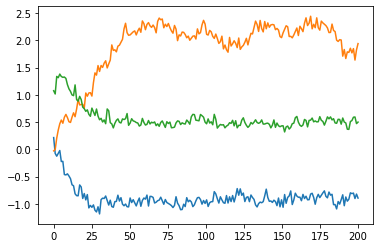

In [10]:

model = BayesNet()
# 实例化优化器，优化的对象就是上述模型
trainer = GMpreOptimizerV2(model, alpha=0.02, N = 7, deep = 3)

parameter_trace = trainer.fit(data, num_steps=200)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i in range(trainer.d):
    plt.plot(line,parameter_trace[:,i],label="par"+str(i))
plt.show()

# 对比三种采样的收敛速度

100%|██████████| 1000/1000 [35:06<00:00,  2.11s/it]


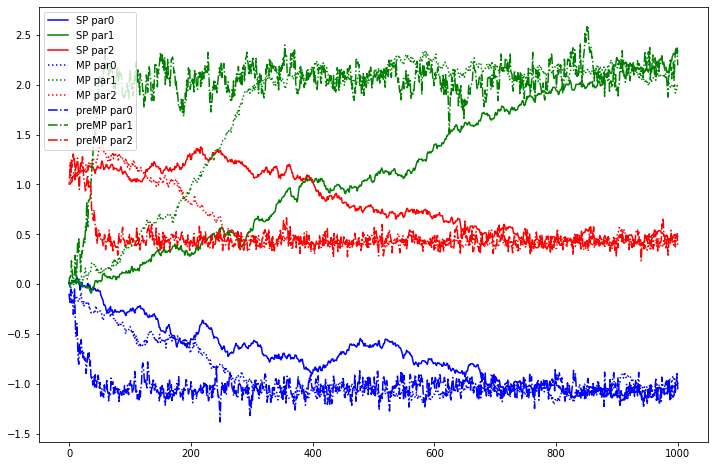

In [96]:
# 1.MH
model = BayesNet_o()
# 实例化优化器，优化的对象就是上述模型
trainer = MetropolisOptimizer(model, alpha=0.02)
parameter_trace = trainer.fit(data, num_steps=1000)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
colors = 'bgr'
for i,j in zip(range(trainer.d),colors):
    plt.plot(line,parameter_trace[:,i],label="SP par"+str(i),color = j,linestyle="-") 
    
# 2.GMP   
model = BayesNet()
# 实例化优化器，优化的对象就是上述模型
trainer = GMOptimizer(model, alpha=0.02,N = 7)
parameter_trace = trainer.fit(data, num_steps=1000)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i,j in zip(range(trainer.d),colors):
    plt.plot(line,parameter_trace[:,i],label="MP par"+str(i),color = j,linestyle=":")   
    
model = BayesNet()
# 实例化优化器，优化的对象就是上述模型
trainer = GMpreOptimizerV2(model, alpha=0.02, N = 7, deep = 3)
parameter_trace = trainer.fit(data, num_steps=1000)
sample_num = parameter_trace.shape[0]
line = np.linspace(0,sample_num,sample_num)
for i,j in zip(range(trainer.d),colors):
    plt.plot(line,parameter_trace[:,i],label="preMP par"+str(i),color = j,linestyle="-.")
    
plt.legend()
plt.show()